In [1]:
%load_ext sympyprinting
%matplotlib inline
import matplotlib.pyplot as plt
import sympy
from IPython.display import display
sympy.init_printing(use_unicode=False, wrap_line=False, no_global=True)
import scipy.constants
import numpy as np

/home/ash/anaconda2/envs/python3/lib/python3.5/site-packages/IPython/extensions/sympyprinting.py:31: UserWarning: The sympyprinting extension has moved to `sympy`, use `from sympy import init_printing; init_printing()`
  warnings.warn("The sympyprinting extension has moved to `sympy`, "


# Equation of motion - SDE to be solved

### $\ddot{q}(t) + \Gamma_0\dot{q}(t) + \Omega_0^2 q(t) -  \dfrac{1}{m} F(t) = 0 $

#### where q = x, y or z

Where $F(t) = \mathcal{F}_{fluct}(t) + F_{feedback}(t)$

Taken from page 46 of 'Dynamics of optically levitated nanoparticles in high vacuum' - Thesis by Jan Gieseler 

Using $\mathcal{F}_{fluct}(t) = \sqrt{2m \Gamma_0 k_B T_0}\dfrac{dW(t)}{dt}$

and $F_{feedback}(t) = \Omega_0 \eta q^2 \dot{q}$

Taken from page 49 of 'Dynamics of optically levitated nanoparticles in high vacuum' - Thesis by Jan Gieseler 

we get the following SDE:

$\dfrac{d^2q(t)}{dt^2} + (\Gamma_0 - \Omega_0 \eta q(t)^2)\dfrac{dq(t)}{dt} + \Omega_0^2 q(t) - \sqrt{\dfrac{2\Gamma_0 k_B T_0}{m}} \dfrac{dW(t)}{dt} = 0$

split into 2 first order ODE/SDE s

letting $v = \dfrac{dq}{dt}$

$\dfrac{dv(t)}{dt} + (\Gamma_0 - \Omega_0 \eta q(t)^2)v + \Omega_0^2 q(t) - \sqrt{\dfrac{2\Gamma_0 k_B T_0}{m}} \dfrac{dW(t)}{dt} = 0$

therefore

$\dfrac{dv(t)}{dt} = -(\Gamma_0 - \Omega_0 \eta q(t)^2)v - \Omega_0^2 q(t) + \sqrt{\dfrac{2\Gamma_0 k_B T_0}{m}} \dfrac{dW(t)}{dt} $

$v = \dfrac{dq}{dt}$ therefore $dq = v~dt$

\begin{align}
dq&=v\,dt\\
dv&=[-(\Gamma_0-\Omega_0 \eta q(t)^2)v(t) - \Omega_0^2 v(t)]\,dt + \sqrt{\frac{2\Gamma_0 k_B T_0}m}\,dW
\end{align}


### Apply Milstein Method to solve

Consider the autonomous Itō stochastic differential equation

${\mathrm  {d}}X_{t}=a(X_{t})\,{\mathrm  {d}}t+b(X_{t})\,{\mathrm  {d}}W_{t}$

Taking $X_t = q_t$ for the 1st equation above (i.e. $dq = v~dt$) we get:

$$ a(q_t) = v $$
$$ b(q_t) = 0 $$

Taking $X_t = v_t$ for the 2nd equation above (i.e. $dv = ...$) we get:

$$a(v_t) = -(\Gamma_0-\Omega_0\eta q(t)^2)v - \Omega_0^2 q(t)$$ 
$$b(v_t) = \sqrt{\dfrac{2\Gamma_0 k_B T_0}m}$$

${\displaystyle b'(v_{t})=0}$ therefore the diffusion term does not depend on ${\displaystyle v_{t}}$ , the Milstein's method in this case is therefore equivalent to the Euler–Maruyama method.

We then construct these functions in python:

In [191]:
def a_q(t, v, q):
    return v

def a_v(t, v, q):
    return -(Gamma0 - Omega0*eta*q**2)*v - Omega0**2*q

def b_v(t, v, q):
    return np.sqrt(2*Gamma0*k_b*T_0/m)


Using values obtained from fitting to data from a real particle we set the following constant values describing the system. Cooling has been assumed to be off by setting $\eta = 0$.

In [183]:
Gamma0 = 4000 # radians/second
Omega0 = 75e3*2*np.pi # radians/second
eta = 0.5e7
T_0 = 300 # K
k_b = scipy.constants.Boltzmann # J/K
m = 3.1e-19 # KG

partition the interval [0, T] into N equal subintervals of width $\Delta t>0$:
$ 0=\tau _{0}<\tau _{1}<\dots <\tau _{N}=T{\text{ with }}\tau _{n}:=n\Delta t{\text{ and }}\Delta t={\frac {T}{N}}$


In [184]:
dt = 1e-10
tArray = np.arange(0, 100e-6, dt)

In [185]:
print("{} Hz".format(1/dt))

10000000000.0 Hz


set $Y_{0}=x_{0}$

In [186]:
q0 = 0
v0 = 0
q = np.zeros_like(tArray)
v = np.zeros_like(tArray)
q[0] = q0
v[0] = v0

Generate independent and identically distributed normal random variables with expected value 0 and variance dt

In [187]:
np.random.seed(88)

dwArray = np.random.normal(0, np.sqrt(dt), len(tArray)) # independent and identically distributed normal random variables with expected value 0 and variance dt

Apply Milstein's method (Euler Maruyama if $b'(Y_{n}) = 0$ as is the case here):

recursively define $Y_{n}$ for $ 1\leq n\leq N $ by

$ Y_{{n+1}}=Y_{n}+a(Y_{n})\Delta t+b(Y_{n})\Delta W_{n}+{\frac  {1}{2}}b(Y_{n})b'(Y_{n})\left((\Delta W_{n})^{2}-\Delta t\right)$

Perform this for the 2 first order differential equations:

In [188]:
#%%timeit

for n, t in enumerate(tArray[:-1]):
    dw = dwArray[n]
    v[n+1] = v[n] + a_v(t, v[n], q[n])*dt + b_v(t, v[n], q[n])*dw + 0
    q[n+1] = q[n] + a_q(t, v[n], q[n])*dt + 0


We now have an array of positions, $v$, and velocities $p$ with time $t$.

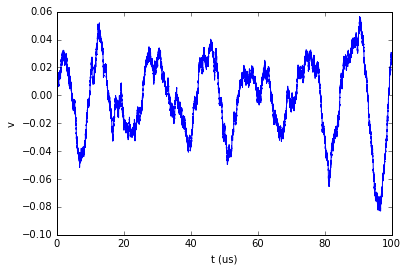

In [189]:
plt.plot(tArray*1e6, v)
plt.xlabel("t (us)")
plt.ylabel("v")

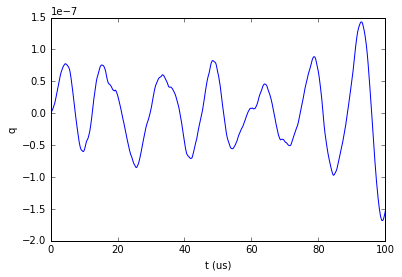

In [190]:
plt.plot(tArray*1e6, q)
plt.xlabel("t (us)")
plt.ylabel("q")

Alternatively we can use a derivative-free version of Milsteins method as a two-stage kind-of Runge-Kutta method, documented in wikipedia (https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_method_%28SDE%29) or the original in arxiv.org https://arxiv.org/pdf/1210.0933.pdf.

In [11]:
q0 = 0
v0 = 0
X = np.zeros([len(tArray), 2])
X[0, 0] = q0
X[0, 1] = v0

In [12]:
def a(t, X):
    q, v = X
    return np.array([v, -(Gamma0 - Omega0*eta*q**2)*v - Omega0**2*q])

def b(t, X):
    q, v = X
    return np.array([0, np.sqrt(2*Gamma0*k_b*T_0/m)])

In [13]:
%%timeit

S = np.array([-1,1])
for n, t in enumerate(tArray[:-1]):
    dw = dwArray[n]
    K1 = a(t, X[n])*dt + b(t, X[n])*(dw - S*np.sqrt(dt))
    Xh = X[n] + K1
    K2 = a(t, Xh)*dt + b(t, Xh)*(dw + S*np.sqrt(dt))
    X[n+1] = X[n] + 0.5 * (K1+K2)


1 loop, best of 3: 2.33 s per loop


In [14]:
q = X[:, 0]
v = X[:, 1]

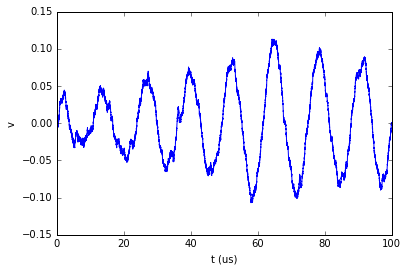

In [15]:
plt.plot(tArray*1e6, v)
plt.xlabel("t (us)")
plt.ylabel("v")

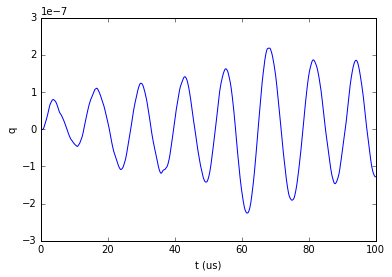

In [16]:
plt.plot(tArray*1e6, q)
plt.xlabel("t (us)")
plt.ylabel("q")